In [11]:
import matplotlib.pyplot as plt
import numpy as np
import corner as corner
from scipy.stats import norm
from scipy.special import logsumexp

# Figure settings
### FIGURE SIZES
fig_width_pt = 2 * 246.0  # Get this from LaTeX using \the\columnwidth (this is for prd)
inches_per_pt = 1.0 / 72.27  # Convert pt to inch
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width * golden_mean  # height in inches
print(fig_width)
square_size = [fig_width, fig_width]
rect_size = [fig_width, fig_height]
long_size = [1.5 * fig_width, fig_height]
longest_size = [2 * fig_width, fig_height]
vert_rect_size = [fig_width, 2 * fig_height]
vert_square_size = [fig_width, 2 * fig_width]
vert_long_size = [1.5 * fig_width, 2 * fig_height]


# The parameters below are suitable for plots...
params = {
    "axes.labelsize": 18,
    "axes.titlesize": 24,
    "font.size": 18,
    "legend.fontsize": 18,
    "font.family": "serif",
    "font.sans-serif": ["Bitstream Vera Sans"],
    "mathtext.fontset": "cm",
    "font.serif": ["Computer Modern Roman"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "text.usetex": True,
    "text.latex.preamble": r"""\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}""",
    "figure.figsize": rect_size,
}

# ...and you need to import them as entries in the rcparams dictionary
plt.rcParams.update(params)

6.807804068078041


In [12]:
# path with GMM saved samples
gmm_data = "../data/GMM/"

# load samples
samples = np.load(gmm_data+"samples_GMM.npy", allow_pickle=True)[()]

# load simulated observed samples
obs = np.load(gmm_data+"observed.npy", allow_pickle=True)[()]

# load raynest output
raynest_samples = np.load(gmm_data+"raynest_samples.npy", allow_pickle=True)[()]

# load raynest evidence
Z = np.load(gmm_data+"raynest_evidence.npy", allow_pickle=True)[()]

# number of components explored with raynest for product space
num_components = np.array([1,2,3,4,5,6,7,8,9])

In [13]:
def gmm(x, weights, means, stds):
    """
    Vectorized 1D Gaussian Mixture Model.
    
    Parameters
    ----------
    x:array_like
        data points
    weights:array_like
        mixture weights (must sum to 1)
    means:array_like
        means of Gaussians
    stds:array_like
        std deviations of Gaussians (positive)
    
    Returns
    -------
    log_mixture:float 
        log GMM computed on the 1D samples x
    """
    # convert to array to ensure vectorization
    x = np.atleast_1d(x)
    weights = np.asarray(weights)
    means = np.asarray(means)
    stds = np.asarray(stds)

    # log pdf of each Gaussian at each x
    log_probs = norm.logpdf(x[:, None], loc=means[None, :], scale=stds[None, :])

    # add weight and sum over the components
    log_weighted = log_probs + np.log(weights[None, :])
    log_mixture = logsumexp(log_weighted, axis=1)
    
    return log_mixture

In [14]:
# injected Mixture parameters
Ncomp = 3
means = [2., 3., 0.]
stds = [0.05, 1., 0.4]
weights = [0.1, 0.6, 0.3]

In [15]:
# set up for GMM posterior
mins = obs.min(axis=0)
maxs = obs.max(axis=0)
n_grid = 100
x = np.linspace(mins[0], maxs[0], n_grid)

# true distribution
true_pdf = np.exp(gmm(x, weights, means, stds))

In [16]:
# PDFs percentiles
all_pdfs = []
for s in samples['samples']:
    all_pdfs.append(np.exp(gmm(x, np.array(s['pi']).flatten(), 
                               np.array(s['mu']).flatten(),
                               np.sqrt(np.array(s['sigma']).flatten()))))

ll, l, m, h, hh = np.percentile(all_pdfs, q=[5, 16, 50, 84, 95], axis=0)

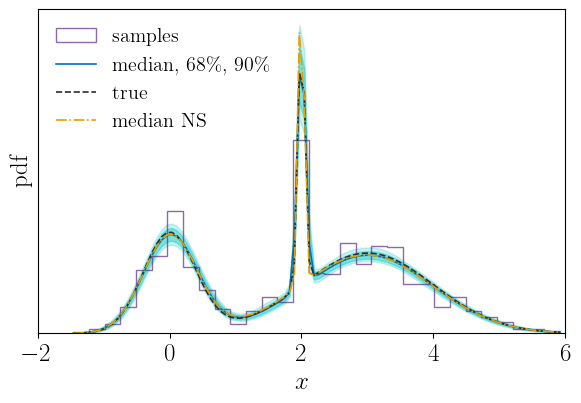

In [17]:
# plot for the inferred GMM
fig = plt.figure(figsize=rect_size)

# observations
plt.hist(obs, bins=int(np.sqrt(len(obs))), density=True, color='#5A2D82', histtype='step', alpha=.7, lw=1., label='samples')

# inferred GMM
plt.plot(x, m, color='#0072B2', lw=1.2, alpha=1., label=r'median, 68$\%$, 90$\%$')
plt.fill_between(x, l, h, color='darkturquoise', alpha=.45)
plt.fill_between(x, ll, hh, color='mediumturquoise', alpha=.3)

# true distribution
plt.plot(x, true_pdf, color='#2E2E2E', linestyle='--', lw=1.2, alpha=1., label='true')

# raynest median
m = np.median([np.exp(gmm(x, s[:,2], s[:,0], s[:,1])) for s in raynest_samples], axis=0)
plt.plot(x, m, color='#E69F00', linestyle='-.', lw=1.2, label='median NS')

# Remove y-axis ticks and ticklabels
plt.gca().yaxis.set_ticks([])
plt.gca().yaxis.set_ticklabels([])

plt.legend(loc='upper left', frameon=False, fontsize=14.5)

plt.ylabel('pdf')
plt.xlabel('$x$')
plt.xlim(-2., 6.)

plt.savefig("../plots/GMM/Figure7.pdf", bbox_inches='tight')
plt.show()

In [18]:
# extract number samples
nsamples = []
for s in samples['samples']:
    nsamples.append(s['n'])

nsamples = np.array(nsamples)

In [19]:
# log bayes factor relative to the maximum
logB = Z - Z[2]

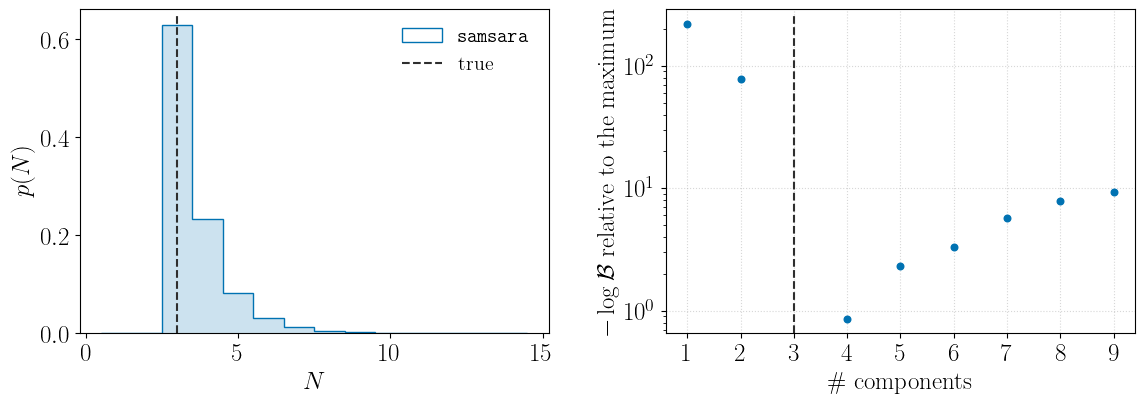

In [20]:
## posterior on the number vs -logB w.r.t. the injected number

# set the figure
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(2.*fig_width, fig_height), gridspec_kw={'wspace':.25})

# set the binning
bins_with_integer_edges= np.arange(1,np.max(nsamples)+1,1) - 0.5
kwargs = dict(
    bins=bins_with_integer_edges,
    density=True,
)

axs[0].hist(
    nsamples,
    histtype="stepfilled",
    color="#0072B2",
    alpha=0.2,
    label="__nolegend__",
    **kwargs,
)

axs[0].hist(
    nsamples,
    histtype="step",
    color="#0072B2",
    alpha=1,
    label="\\texttt{samsara}",
    **kwargs,
)

axs[0].set_ylabel("$p(N)$")
axs[0].set_xlabel("$N$")

# true value
axs[0].axvline(Ncomp, color='#2E2E2E', lw=1.5, linestyle='--', label='true', ymax=.98, alpha=1.)

# set the legend
axs[0].legend(loc='upper right', frameon=False, fontsize=14.5)

# -logB plot
axs[1].scatter(num_components, -logB, marker='.', color='#0072B2', s=90, zorder=10)
axs[1].axvline(Ncomp, color='#2E2E2E', lw=1.5, linestyle='--', label='true', ymax=.98, alpha=1.)
axs[1].set_xlabel("$\\#$ components")
axs[1].set_ylabel("$-\\log \\mathcal{B}$ relative to the maximum")
axs[1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1].grid(True, linestyle=':', linewidth=0.8, alpha=0.5)
axs[1].set_yscale('log')

plt.savefig("../plots/GMM/Figure8.pdf", bbox_inches="tight")
plt.show()